# BEMM459J - Database Technologies for Business Analytics

In [1]:
# Import library
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the Database
conn=sqlite3.connect('invoicing.db')
cur=conn.cursor()
print(type(cur))
print (sqlite3.sqlite_version)

<class 'sqlite3.Cursor'>
3.33.0


### Show Tables

In [58]:
# List of all tables

def tables_in_sqlite_db(conn):
    cursor = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = [
        v[0] for v in cursor.fetchall()
        if v[0] != "sqlite_sequence"
    ]

    cursor.close()
    return tables

tables = tables_in_sqlite_db(conn)
#print tables
print(tables)

['Project', 'CompanyType', 'Company', 'Contact', 'ProductsServices', 'Invoice_ProductsServices', 'Invoice']


## SQL - CRUD operations (Create, Read, Update, Delete)


DML(Data Manipulation Language) & TCL(transaction Control Language)

### Create

In [71]:
# Add a ner invoice

inputcompanyRFC=input('Enter company identifier (RFC):')
inputprojectID=int(input('Enter Project number:'))
inputinvoiceDescription=input('Enter invoice description:')
inputinvoiceDate=input('Enter invoice date:')
inputinvoiceTotal=int(input('Enter invoice total:'))
inputinvoiceBalance=int(input('Enter paid amount:'))         


qry="insert into Invoice (companyRFC,projectID,invoiceDescription,invoiceDate,invoiceTotal,invoiceBalance) values (?,?,?,?,?,?);"

try:
        cur.execute(qry, (inputcompanyRFC,inputprojectID,inputinvoiceDescription,inputinvoiceDate,inputinvoiceTotal,inputinvoiceBalance))
        print ('New invoice successfully added')
        conn.commit()
except:
        print ('Error in adding invoice')
        conn.rollback()

Enter company identifier (RFC):PDI020320KF4
Enter Project number:1
Enter invoice description:Concrete Structure
Enter invoice date:01/01/2020
Enter invoice total:10000
Enter paid amount:5000
New invoice successfully added


In [72]:
# Query and display tha last invoice created

# Query to show one invoice orderd by InvoiceID in desc order
qry="select * from Invoice order by invoiceID desc limit 1;"

# Execute the query on SQLite
cur.execute(qry)

# Fetch and display 
row=cur.fetchall()

print (row)

[(24, 'PDI020320KF4', 1, 'Concrete Structure', '01/01/2020', 10000, 5000, 'Wire Transfer', 0.16)]


### Read

Show customer´s invoices and the amount they have to pay.  

In [73]:
# Query and display records from two different tables for customers (not suppliers), finally add a new column with
#the difference of the invoice total and the amount that has been paid

# Prepare the query String
qry2=pd.read_sql_query("SELECT Company.companyName,Company.companyTypeID,Invoice.invoiceDescription,Invoice.invoiceTotal,Invoice.invoiceBalance, Invoice.invoiceTotal-Invoice.invoiceBalance AS TotalDueAmount FROM Company LEFT JOIN Invoice ON Invoice.companyRFC=Company.companyRFC WHERE Company.CompanyTypeID='Customer'",conn)

"""
SELECT Company.companyName,Company.companyTypeID,Invoice.invoiceDescription,
Invoice.invoiceTotal,Invoice.invoiceBalance, Invoice.invoiceTotal-Invoice.invoiceBalance AS TotalDueAmount
FROM Company 
LEFT JOIN Invoice ON Invoice.companyRFC=Company.companyRFC 
WHERE Company.CompanyTypeID="Customer"
"""
# Show the query ina Panda's Dataframe
qry2                       

,companyName,CompanyTypeID,invoiceDescription,invoiceTotal,invoiceBalance,TotalDueAmount
0,"PLUS DIGITAL, SA DE CV",Customer,Concrete Structure,10000,5000,5000
1,"PLUS DIGITAL, SA DE CV",Customer,Sand and gravel bases,80032,80000,32
2,SERVICIO DE CONSULTORIA DE VALOR AGREGADO SC,Customer,Metal,10000,0,10000
3,SERVICIO DE CONSULTORIA DE VALOR AGREGADO SC,Customer,Metal structures in foundation masks,168906,100000,68906
4,SERVICIO DE CONSULTORIA DE VALOR AGREGADO SC,Customer,Monolithic foundations,435800,230000,205800
5,Víctor Adrián del Ángel Espinosa,Customer,Heat and waterproofing,35000,15000,20000
6,Víctor Adrián del Ángel Espinosa,Customer,Subfloor elements,40000,4000,36000
7,"Formas e Imágenes, S.A. de C.V.",Customer,Heat and waterproofing,50000,25000,25000
8,"AGROCOSTA DE BAJA CALIFORNIA, S.A. DE C.V.",Customer,Desarrollo Plano,5916,1000,4916
9,AZTECA AUTOTRANSPORTES DE CARGA,Customer,Desarrollo Tuberia,14000,500,13500


In [74]:
# Query and display records from two different tables for customers (not suppliers),  add a new column with
#the difference of the invoice total and the amount that has been paid and SUM the Due Amount per Company

# Prepare the query String
qry3=pd.read_sql_query("SELECT Company.companyName,Company.companyTypeID,SUM(Invoice.invoiceTotal) AS 'Total Invoices',SUM(Invoice.invoiceBalance) AS 'Total Paid', SUM(Invoice.invoiceTotal-Invoice.invoiceBalance) AS 'Total Due Amount' FROM Company LEFT JOIN Invoice ON Invoice.companyRFC=Company.companyRFC WHERE Company.CompanyTypeID='Customer' GROUP BY companyName;",conn)

"""
SELECT Company.companyName,Company.companyTypeID,
SUM(Invoice.invoiceTotal) AS 'Total Invoices',SUM(Invoice.invoiceBalance) AS 'Total Paid', 
SUM(Invoice.invoiceTotal-Invoice.invoiceBalance) AS 'Total Due Amount'
FROM Company 
LEFT JOIN Invoice ON Invoice.companyRFC=Company.companyRFC 
WHERE Company.CompanyTypeID="Customer"
GROUP BY companyName
"""
# Show the query ina Panda's Dataframe
qry3

,companyName,CompanyTypeID,Total Invoices,Total Paid,Total Due Amount
0,"AGROCOSTA DE BAJA CALIFORNIA, S.A. DE C.V.",Customer,5916,1000,4916
1,AZTECA AUTOTRANSPORTES DE CARGA,Customer,14000,500,13500
2,"Formas e Imágenes, S.A. de C.V.",Customer,50000,25000,25000
3,"PLUS DIGITAL, SA DE CV",Customer,90032,85000,5032
4,SERVICIO DE CONSULTORIA DE VALOR AGREGADO SC,Customer,614706,330000,284706
5,SERVICIOS AMBIENTALES S.A DE R.L.D,Customer,250000,100000,150000
6,Víctor Adrián del Ángel Espinosa,Customer,75000,19000,56000


### Data visualisation with Pandas 

In [75]:
#Group by the user Company the sum the DueAmount
ret=qry2.groupby(['companyName']).sum()[['TotalDueAmount']]
#Change the name of the columns
ret.columns = ['Total Due Amount']
ret.index.names = ['Company']
#Sort values by Total Due Amount
ret_sorted=ret.sort_values(by='Total Due Amount',ascending=False)
ret_sorted

,Total Due Amount
Company,
SERVICIO DE CONSULTORIA DE VALOR AGREGADO SC,284706
SERVICIOS AMBIENTALES S.A DE R.L.D,150000
Víctor Adrián del Ángel Espinosa,56000
"Formas e Imágenes, S.A. de C.V.",25000
AZTECA AUTOTRANSPORTES DE CARGA,13500
"PLUS DIGITAL, SA DE CV",5032
"AGROCOSTA DE BAJA CALIFORNIA, S.A. DE C.V.",4916


In [77]:
#Create a dataframe with top 5 companies with more Debt
ret_sorted_5= ret_sorted[:5]
ret_sorted_5
#Create a dataframe with the rest of the companies
ret_others_df= ret_sorted[5:]
#Sum all the Companies other than the top 5
Other_companies=ret_others_df['Total Due Amount'].sum()
#Create a new row with the sum of all the Total Due Amount other than the top 5
new_row = pd.DataFrame(data = {'Total Due Amount' : [Other_companies]},index=['Others'])
#Create a new dataframe with the top 5 companies  by the Total Due Amount and the rest of the companies
ret_final = pd.concat([ret_sorted_5, new_row])
ret_final.index.names = ['Company']
ret_final

,Total Due Amount
Company,
SERVICIO DE CONSULTORIA DE VALOR AGREGADO SC,284706
SERVICIOS AMBIENTALES S.A DE R.L.D,150000
Víctor Adrián del Ángel Espinosa,56000
"Formas e Imágenes, S.A. de C.V.",25000
AZTECA AUTOTRANSPORTES DE CARGA,13500
Others,9948


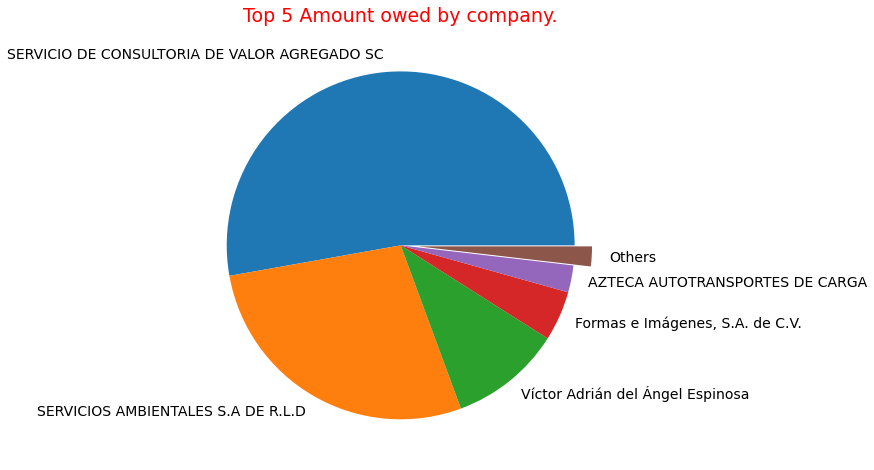

In [78]:
#Plot Top 5 most popular users by Total Due Amount.
myexplode = [0, 0, 0, 0,0,.1]
ret_final.plot.pie(subplots=True, figsize=(16, 8), explode = myexplode,legend=None, fontsize=14)
plt.title('Top 5 Amount owed by company.', fontsize=19,  color='red')
plt.ylabel(None)
plt.show()

### Update

In this part we will choose an invoice and register a Payment.

In [79]:
# We will Update the last invoice created
qry4=pd.read_sql_query("select * from Invoice order by invoiceID desc limit 1;",conn)
qry4

,invoiceID,companyRFC,projectID,invoiceDescription,invoiceDate,invoiceTotal,invoiceBalance,invoiceMethod,invoicetaxRate
0,24,PDI020320KF4,1,Concrete Structure,01/01/2020,10000,5000,Wire Transfer,0.16


In [80]:
# Ask for the number of the invoice to modify and the amount that amount paid
inputinvoiceID=int(input('Which invoice you want to pay?'))
inputinvoiceAmount=int(input('Amount:'))

#Extract the Current Balance from chosen invoice
qr6="select Invoice.invoiceBalance from Invoice where invoiceID=?;"
current_balance=cur.execute(qr6,(inputinvoiceID,)).fetchone()[0]

#Add the new amount paid to the current balance
current_balance_plus_amount=current_balance+inputinvoiceAmount
print('New Balance:',current_balance_plus_amount)

#Update the new amount to the selected invoice
qry5='update Invoice set invoiceBalance=? where invoiceID=?'

try:
         cur.execute(qry5, (current_balance_plus_amount,inputinvoiceID))
         print ('Payment successfully registered')
         conn.commit()
except:
         print ('Error please check your info .. rollback')
         conn.rollback()

Which invoice you want to pay?24
Amount:2000
New Balance: 7000
Payment successfully registered


In [81]:
# Invoice Updated
qry7=pd.read_sql_query("select * from Invoice order by invoiceID desc limit 1;",conn)
qry7

,invoiceID,companyRFC,projectID,invoiceDescription,invoiceDate,invoiceTotal,invoiceBalance,invoiceMethod,invoicetaxRate
0,24,PDI020320KF4,1,Concrete Structure,01/01/2020,10000,7000,Wire Transfer,0.16


### Delete

In this part we will delete an invoice

In [82]:
# Ask for the number of the invoice to Delete
inputinvoiceID2=int(input('Which invoice you want to delete?'))

#Delete the selected invoice
qry8='delete from Invoice where invoiceID=?'

try:
         cur.execute(qry8, (inputinvoiceID2,))
         print ('Invoice successfully deleted')
         conn.commit()
except:
         print ('Error please check your info .. rollback')
         conn.rollback()

Which invoice you want to delete?24
Invoice successfully deleted


In [83]:
# Invoice Deleted
qry9=pd.read_sql_query("select * from Invoice order by invoiceID desc limit 1;",conn)
qry9

,invoiceID,companyRFC,projectID,invoiceDescription,invoiceDate,invoiceTotal,invoiceBalance,invoiceMethod,invoicetaxRate
0,19,ABC881019DE7,2,Desarrollo Plano,21/04/2021,5916,1000,Wire Transfer,0.16


## NoSQL - CRUD operations (Create, Read, Update, Delete)

In [2]:
import xml.etree.ElementTree as ET
import pymongo


In [4]:
mongoclient = pymongo.MongoClient("mongodb://localhost:7001/")

#Check what databases exist 
print(mongoclient.list_database_names())

['admin', 'config', 'invoice', 'invoice1', 'invoice3', 'local', 'school', 'test1']


In [5]:
#Create the Database and the Collection
mydb = mongoclient["invoice3"]
mycol = mydb["invoices"]


## Create - Import an XML invoice to MongoDB

Import real invoices with a Digital Signature made by the goverment. We will import the XML files into MongoDB,  and Insert that invoince into the SQL Database.

In [17]:
#Choose the XML to be imported. In the future we will use an API from the goverment that drops the XML
#files into a Hot folder, so this process will be automated
inputinvoice_xml=input('Which invoice you want to import?')

Which invoice you want to import?Factura5.xml


In [18]:
#Convert the invoices in XML to JSON
#Use the ElementTree module to parse a XML File
#Use MongoDB connector module to connect the database
tree = ET.parse(inputinvoice_xml)

stud = tree.findall('cfdi_Receptor')

for ep in stud:
    Rfc = ep.find('Rfc').text
    Nombre = ep.find('Nombre').text
    ClaveProdServ = ep.find('ClaveProdServ').text
    Descripcion = ep.find('Descripcion').text
    TasaOCuota = ep.find('TasaOCuota').text
    Total = ep.find('Total').text
    MetodoPago = ep.find('MetodoPago').text
    
    stu_dict = [
                {'Rfc': Rfc, 'Nombre': Nombre, 'ClaveProdServ': ClaveProdServ, 'Descripcion': Descripcion, 'TasaOCuota': TasaOCuota, 'Total': Total, 'MetodoPago': MetodoPago}
               ]

    x = mycol.insert(stu_dict)    

for y in mycol.find():
  print(y) 

{'_id': ObjectId('60e9e1508086e9690c97c3d9'), 'Rfc': 'ISE010326TB3', 'Nombre': 'IW SERVICES, S.A. DE C.V.', 'ClaveProdServ': '72101500', 'Descripcion': 'Complemento del Desarrollo de Planos de Trayectorias Actinver Monterrey Piso 8\n', 'TasaOCuota': '0.160000', 'Total': '63684.58', 'MetodoPago': 'PUE'}
{'_id': ObjectId('60e9e2ceebb33de6fd84fa22'), 'Rfc': 'ISE010326TB3', 'Nombre': 'IW SERVICES, S.A. DE C.V.', 'ClaveProdServ': '72101500', 'Descripcion': 'Complemento del Desarrollo de Planos de Trayectorias Actinver Monterrey Piso 8\n', 'TasaOCuota': '0.160000', 'Total': '63684.58', 'MetodoPago': 'PUE'}
{'_id': ObjectId('60e9e4b5ebb33de6fd84fa23'), 'Rfc': 'ISE010326TB3', 'Nombre': 'IW SERVICES, S. A. DE C. V.', 'ClaveProdServ': '72101500', 'Descripcion': 'SUMINISTRO E INSTALACION', 'TasaOCuota': '0.160000', 'Total': '11136.00', 'MetodoPago': 'PUE'}
{'_id': ObjectId('60e9e4cbebb33de6fd84fa24'), 'Rfc': 'IWA970411168', 'Nombre': 'INTERNATIONAL WARE SA DE CVz', 'ClaveProdServ': '72101500', 'D

<ipython-input-18-55b0b6eb4818>:21: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.
  x = mycol.insert(stu_dict)


Here we can Insert the newly imported XML invoice into the SQL Database

In [ ]:
# Insert the invoice into SQL Database

inputcompanyRFC=Rfc
inputprojectID=int(input('Enter Project number:'))
inputinvoiceDescription=Descripcion
inputinvoiceDate='01/01/2020'
inputinvoiceTotal=Total
inputinvoiceBalance=0
inputinvoiceStatus='NotCancelled'

qry="insert into Invoice (companyRFC,projectID,invoiceDescription,invoiceDate,invoiceTotal,invoiceBalance) values (?,?,?,?,?,?);"

try:
        cur.execute(qry, (inputcompanyRFC,inputprojectID,inputinvoiceDescription,inputinvoiceDate,inputinvoiceTotal,inputinvoiceBalance))
        print ('New invoice successfully added')
        conn.commit()
except:
        print ('Error in adding invoice')
        conn.rollback()

In [20]:
# Here we can see the invoice inthe SQL Database. This is the last invoice created
qry10=pd.read_sql_query("select * from Invoice order by invoiceID desc limit 1;",conn)
qry10

,invoiceID,companyRFC,projectID,invoiceDescription,invoiceDate,invoiceTotal,invoiceBalance,invoiceMethod,invoicetaxRate
0,30,SSC9205061AA,1,PROYECTO PRELIMINAR INSTALACION ELECTRICA,01/01/2020,12206.43,0,Wire Transfer,0.16


## Query  and sorting documents

Two examples of queries that can be made

In [6]:
#Show all the companies and total of all invoices sorting by descending order
for x in mycol.find({},{ "_id":0, "Nombre":1, "Total":1}).sort("Total",-1):
    print(x)
    
    

{'Nombre': 'IW SERVICES, S.A. DE C.V.', 'Total': '63684.58'}
{'Nombre': 'INTERNATIONAL WARE SA DE CVz', 'Total': '12760.00'}
{'Nombre': 'SOFTTEK SERVICIOS CORPORATIVOS S.A. DE C.V.', 'Total': '12206.43'}
{'Nombre': 'IW SERVICES, S. A. DE C. V.', 'Total': '11136.00'}
{'Nombre': 'INTERNATIONAL WARE SA DE CVz', 'Total': '10440.00'}


In [20]:
#Make a Query of a Specific Document and specific Amount

inputcompany=input('What company you are looking for:')
inputamount=input('Enter the Total of the invoice:')

myquery = {"Nombre": inputcompany,"Total": inputamount }
mydoc = mycol.find(myquery,{ "_id":0,"Rfc":0,"TasaOCuota":0,"MetodoPago":0,"MetodoPago":0,"ClaveProdServ":0,})

for x in mydoc:
    print(x)

What company you are looking for:SOFTTEK SERVICIOS CORPORATIVOS S.A. DE C.V.
Enter the Total of the invoice:12206.43
{'Nombre': 'SOFTTEK SERVICIOS CORPORATIVOS S.A. DE C.V.', 'Descripcion': 'PROYECTO PRELIMINAR INSTALACION ELECTRICA', 'Total': '12206.43'}


## Delete an Update

I am showing how to delete and Update a documet for the assigment, but in the real application you should not be able to delete or update official invoices.

In [140]:
#This is just to show how to delete a document.
myquery = { "Rfc": "ISE010326TB3" }
mycol.delete_one(myquery)


In [ ]:
#This is just to show how to update a document.
#In the real application it is not allowed to change documents.
# In fututre developments you will be able to change the status of an invoice to CANCELLED,
# and avoid duplicates by comparing cryptographic hashes of the invoice digital signature.

myquery = { "Total": "11252.00" }
newvalues = { "$set": { "Total": "12000.00" } }
mycol.update_one(myquery, newvalues)

#print documents in the collection with the updated document.
for x in mycol.find():
    print(x)
